In linear regression we are trying to approximate a system using a linear combination of inputs.  Given a set of inputs and outputs, we want to produce something like:

$$y(x) = a + bx$$

To evaluate the model that we use, we need a function which provides an indication of how far off our estimate was from the true y values.  The most common of these is squared error:

$$Error(a, b) = {E}[(y - y(x))^2]$$

It is possible to solve this directly, but it is computationally expensive.  In fact it can often be faster to approximate the answer through gradient descent as below

In [6]:
import math

def squaredErrors(y, yhat):
    if len(y) != len(yhat): raise "Length of y and yhat has to be the same"
        
    sqrErrors = [ math.pow(i[0] - i[1], 2) for i in zip(y, yhat) ]
    return sum(sqrErrors)

In [21]:
class LinearModel:
    def __init__(self,x, y, errorFunction = squaredErrors):
        self.x = x
        self.a = 0
        self.y = y
        self.errorFunction = squaredErrors
    def generate_yhat(self,b):
        return [self.a + b * xPoint for xPoint in self.x]
    def generate_errors(self,b):
        return self.errorFunction(self.y, self.generate_yhat(b))

In the simplest linear model, we fix a at 0 so that the model is constrained to go through the origin at (0,0).  This means there is just one variable that's free to change, namely b.  We can find the optimum b by taking the current b and looking just  to either side of it and seeing if that increases of decreases the error.  We reach an optimum when both sides of b lead to an increase in error.  Note the linear nature of the model ensures that we'll reach a single global optimum 

In [32]:
def simpleGradientDescent(model, b = 0, increment = 0.1):
    
    def direction_of_change(current, up, down):
        if current < up and current < down:
            return 0
        elif current > up and current < down:
            return 1
        else: return -1
        
    iteration = b
    finished = False
    
    while not finished:
        current,incrDown,incrUp = model.generate_errors(iteration), model.generate_errors(iteration - increment), model.generate_errors(iteration + increment)
        direction = direction_of_change(current, incrUp, incrDown)
        if direction == 0: finished = True
        else:
            iteration = iteration + (increment * direction)
    return iteration
    
x = [1,2,3,4,5,6]
y = [1,2,3,4,5,6]
model = LinearModel(x, y)
simpleGradientDescent(model)

0.9999999999999999

As we can see this converges to the correct value relatively quickly.  This is overly simple in a number of regards, and we will now work on improving those simplicities.  The first is the speed of convergence to the optimum.  Initially, the speed is much too slow.  We are too cautious in moving such a small distance.  Later on we end up moving too quickly.  As we get closer to the true value we would like to make smaller changes to find the exact optimum.  This problem was masked in the case above because the numbers were chosen to work out well but consider the case below:

In [34]:
x = [1,2,3,4,5,6]
y = [1,2,3,4,5,6]
model = LinearModel(x, y)
simpleGradientDescent(model, b = 0.05)

1.0499999999999998

Using an increment of fixed size, we can end up half the distance of the incremet from the true value.  To solve this, we need to make the increment a function of the how far from the optimum we are.  A simple way to do this is to use the gradient of the error function as a proxy for how quickly we can move.  If the gradient is steep we can move quickly as we are far from the max, if the gradient is shallow we need to move more slowly because we are close to the centre (here we're using the fact that the error is normally distributed)

$$Error(b) = \frac{1}{N} \sum\limits_{n=1}^n (y^n - bx^n)$$

$$\frac{dError(b)}{db} = -2 \frac{1}{N}\sum\limits_{n=1}^n (y^n - bx^n)x^n$$

The first thing we need is a fucntion to calculate the gradient of the error given y, x and b

In [72]:
def gradientError(y, x, b):
    insideSummation = [  (i[1] - b * i[0]) * i[0] for i in zip(x,y) ]
    summation = sum(insideSummation)
    return (summation * (-2)) / len(y)

In [73]:
gradientError(x, y, 2)

30.333333333333332

In [91]:
class GradientAscentLinearRegression:
    def __init__(self,x, y, errorFunction = squaredErrors, learningRate = 0.01):
        self.x, self.y = x, y
        self.errorFunction = squaredErrors
        self.b = 1.5
        self.learningRate = learningRate
    def next_b(self):
        change = gradientError(self.y, self.x, self.b)
        return self.b - change * self.learningRate
    def learn(self):
        values = []
        iterations = 0
        while True:
            next_b = self.next_b()
            values.append(self.b)
            if math.fabs((next_b - self.b))  < 0.00001 or iterations > 100:
                break
            self.b = next_b
            iterations +=1 
        return values
            

In [90]:
regression = GradientAscentLinearRegression(x, y)
learning = regression.learn()
print("Done")

-0.15166666666666662
-0.1056611111111112
-0.07361057407407401
-0.051282033271604854
-0.035726483179218116
-0.024889449948188647
-0.01733965013057137
-0.012079956257631475
-0.00841570285948312
-0.00586293965877327
-0.004084514628945435
-0.0028455451914985996
-0.0019823964834106977
-0.001381069550109526
-0.0009621451199095521
-0.0006702944335370553
-0.00046697178869758993
-0.0003253236794591441
-0.00022664216335654963
-0.00015789404047183986
-0.00010999951486190263
-7.66329953538758e-05
-5.338765342988161e-05
-3.719339855612347e-05
-2.5911400994171885e-05
-1.8051609359304166e-05
-1.2575954520199772e-05
-8.761248315725112e-06
Done


To ensure that the algorithm converges, it is important to choose an appropriate learning rate.  If we adjust the value for b too quickly, we are likely to pendulum back and forth past the maximum without ever settling.  This can be seen in the graphs below

In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [107]:
slowRegression = GradientAscentLinearRegression(x, y, learningRate = 0.01)
slowLearning = slowRegression.learn()
tooFastRegression = GradientAscentLinearRegression(x, y, learningRate = 0.09)
tooFastLearning = tooFastRegression.learn()

In [98]:
print(slowLearning, tooFastLearning)

[1.5, 1.3483333333333334, 1.2426722222222222, 1.1690616481481482, 1.1177796148765433, 1.0820531316973252, 1.0571636817491366, 1.0398240316185652, 1.0277440753609337, 1.0193283725014506, 1.0134654328426773, 1.0093809182137319, 1.0065353730222333, 1.0045529765388226, 1.003171906988713, 1.0022097618688035, 1.0015394674352665, 1.0010724956465689, 1.0007471719671097, 1.0005205298037532, 1.0003626357632813, 1.0002526362484194, 1.0001760032530655, 1.0001226155996357, 1.0000854222010795, 1.0000595108000854, 1.000041459190726, 1.0000288832362059] [1.5, -13.666666666666666, 431.2222222222222, -12618.85185185185, 370183.32098765427, -10858680.415637858, 318521322.52537715, -9343292097.07773, 274069901544.61343, -8039383778611.66, 235821924172639.0, -6917443109064046.0, 2.029116645325454e+17, -5.952075492954665e+18, 1.7459421446000352e+20, -5.121430290826769e+21, 1.5022862186425189e+23, -4.4067062413513886e+24, 1.2926338307964075e+26, -3.791725903669462e+27, 1.1122395984097087e+29, -3.262569488668

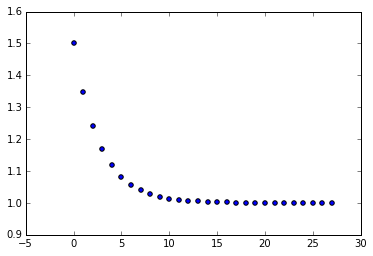

In [99]:
plt.scatter(np.arange(0,len(slowLearning)), slowLearning)

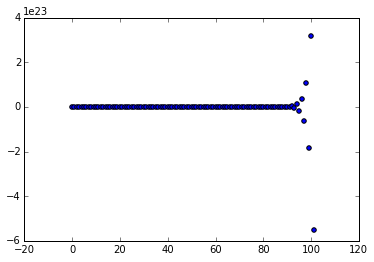

In [108]:
 plt.scatter(np.arange(0,len(tooFastLearning)), tooFastLearning)